In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# scikit-learn
import sklearn

# 수치형 변환
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# PCA (차원 축소 : 주성분분석)
from sklearn.decomposition import PCA

# 문제지, 답안지 분리
from sklearn.model_selection import train_test_split

# 분류 모델
from sklearn.linear_model import LogisticRegression # 분류 모델 (회귀 모델 아님)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier # Tree : 나무
from sklearn.ensemble import RandomForestClassifier # Forest : 나무가 모여서 숲이 됨

# 정규화 / 스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 교차 검증
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV

# 분류 평가 매트릭스
from sklearn.metrics import accuracy_score

# --- 필요한 라이브러리 추가 임포트 ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# matplotlib 차트 스타일을 seaborn 스타일로 설정
sns.set()

# ----------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load (df)

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# EDA

| 컬럼명 | 설명 |
|--------|------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> |
| **bone_length** | 뼈의 길이를 나타내는 수치입니다. 이 값이 클수록 뼈가 길다는 것을 의미합니다. |
| **rotting_flesh** | 살이 썩는 정도를 나타내는 수치입니다. 이 값이 클수록 부패가 심하다는 뜻입니다. |
| **hair_length** | 머리카락 또는 털의 길이를 나타내는 수치입니다. 이 값이 클수록 털이 길다는 의미입니다. |
| **has_soul** | 영혼을 가지고 있는 정도를 나타내는 수치입니다. 이 값이 클수록 영혼이 더 온전하거나 강하다는 것을 의미합니다. |
| **color** | 몬스터의 주된 색깔을 나타내는 범주형 데이터입니다. 예: `white`, `black`, `clear`, `blood` |
| **type** | 예측해야 할 목표(**Target**) 변수입니다. 이 몬스터가 **구울(Ghoul)**, **고블린(Goblin)**, **유령(Ghost)** 중 어떤 종류인지를 나타냅니다. |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> |
| **bl_rf_ratio** | **뼈 길이 대비 썩은 살점** — 뼈 길이에 비해 살점이 얼마나 썩었는지를 나타내는 지표입니다. |
| **bl_hl_ratio** | **뼈 길이 대비 털 길이** — 전체적인 크기에 비해 털이 얼마나 긴지를 나타냅니다. |
| **rf_hl_ratio** | **썩은 살점 대비 털 길이** — 부패 정도와 털 길이 간의 관계를 파악합니다. |
| **humanoid_index** | **인간형 지수** — `bl × hs` 로 계산되며, 뼈대가 길고 영혼이 있을수록 더 인간에 가까운 형태로 가정할 수 있습니다. |
| **decay_index** | **부패 지수** — `rf × hl` 로 계산되며, 살점이 많이 썩고 털도 길다면 특별한 형태의 몬스터일 가능성을 의미합니다. |
| **body_sum** | **신체 합산 지수** — `bl + rf + hl` 로 계산되며, 전체적인 신체 특성을 종합해 “괴물성(monstrosity)” 점수를 나타냅니다. |

In [3]:
df = df.drop('id', axis=1)
df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']
df.head()

,bl,rf,hl,hs,cl,tp
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bl      371 non-null    float64
 1   rf      371 non-null    float64
 2   hl      371 non-null    float64
 3   hs      371 non-null    float64
 4   cl      371 non-null    object 
 5   tp      371 non-null    object 
dtypes: float64(4), object(2)
memory usage: 17.5+ KB


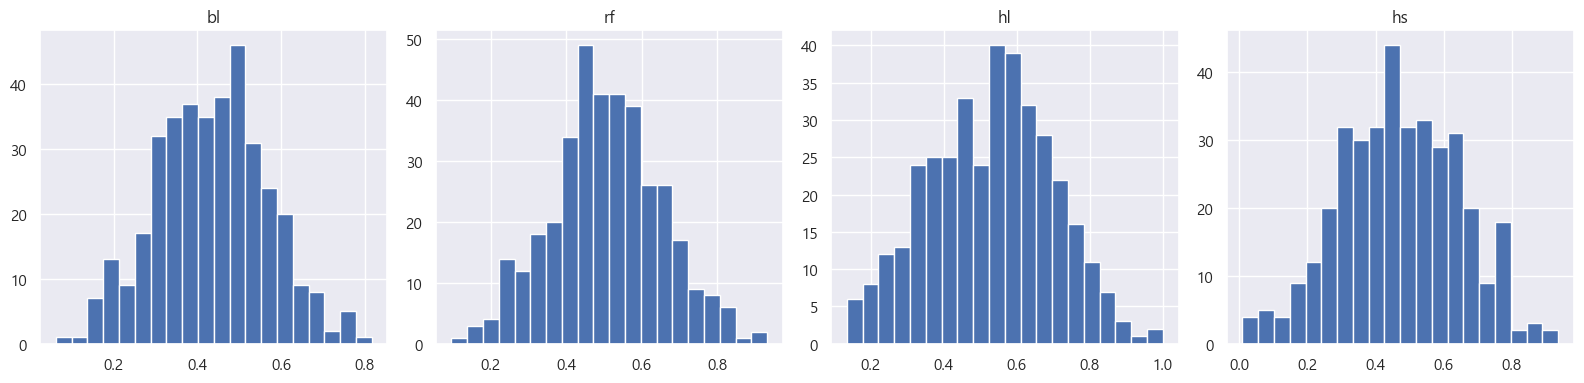

In [5]:
df.hist(figsize=(16, 4), bins=20, layout=(1, 4))
plt.tight_layout()
plt.show()

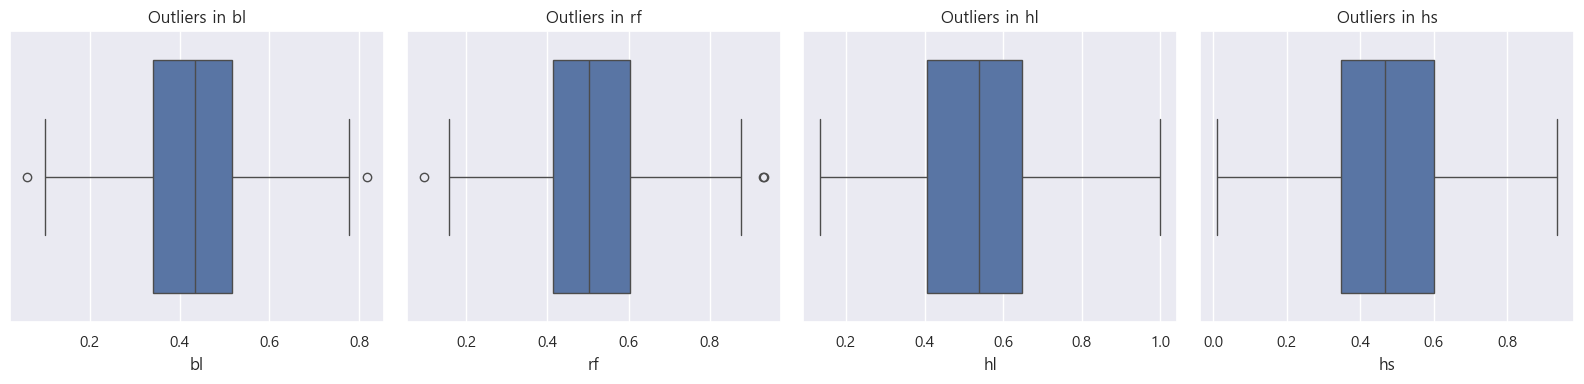

In [6]:
numeric_cols = df.select_dtypes(include='number').columns

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

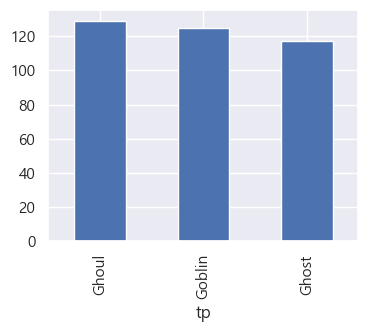

In [7]:
plt.figure(figsize=(4, 3))
df['tp'].value_counts().plot(kind='bar')
plt.show()

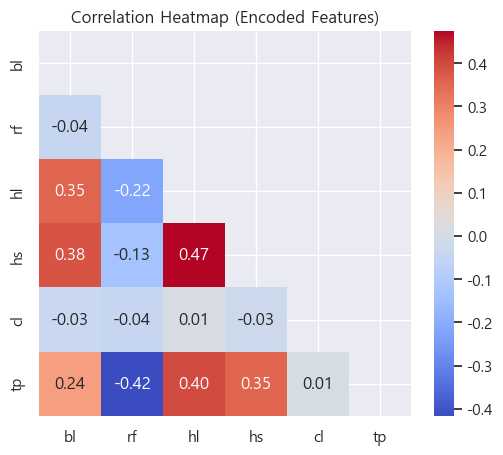

In [8]:
# 원본 데이터프레임(df)을 복사하여 인코딩 진행
df_encoded = df.copy()

# 'cl'과 'tp' 컬럼을 레이블 인코딩으로 숫자로 변환
le = LabelEncoder()
df_encoded['cl'] = le.fit_transform(df_encoded['cl'])
df_encoded['tp'] = le.fit_transform(df_encoded['tp'])

# --- 이제 모든 컬럼이 숫자이므로 히트맵 생성 가능 ---
plt.figure(figsize=(6, 5)) # figsize를 조금 키워 가독성 확보

# 상관관계 행렬 계산
corr_matrix = df_encoded.corr()

# 히트맵 마스크 생성 (중복되는 상단 삼각형 가리기)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap (Encoded Features)')
plt.show()

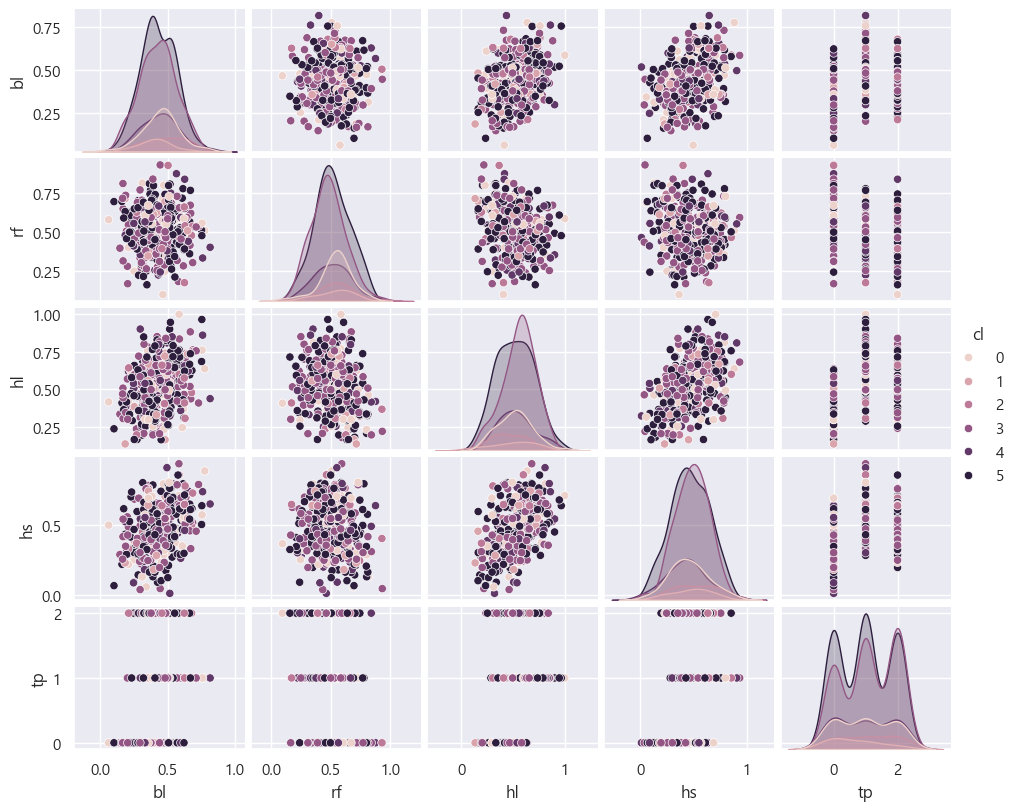

In [9]:
g = sns.pairplot(data = df_encoded,
                 hue="cl" 
                 , diag_kind="kde"
                )
g.fig.set_size_inches(10, 8)
plt.show()

# 공통함수 myscore

In [10]:
# ----------------------------------------------------
# 최고 점수 기록을 위한 글로벌 변수 (실행 전 초기화 필수)
# ----------------------------------------------------
best_scores = None


# ----------------------------------------------------
# 분류용 최종 myscore 함수
# ----------------------------------------------------

def myscore(target, X80=None, y80=None, X20=None, y20=None, model=None, df=None, fi=None, top_n=None):
    """
    [분류용] 모델을 학습/평가하고, 가장 좋았던 Accuracy 점수와 현재 점수를 비교합니다.
    - target: df에서 사용할 타겟(Y) 컬럼의 이름을 문자열로 전달해야 합니다.
    - fi=True일 경우, feature_importances_ 또는 coef_ 를 시각화합니다.
    """
    global best_scores
    precision = 5

    # 데이터 분할
    if df is not None:
        y = df[target]
        X = df.drop(columns=[target], errors='ignore')
        if y.dtype == 'object' or pd.api.types.is_categorical_dtype(y):
            le = LabelEncoder()
            y = le.fit_transform(y)
        X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989, stratify=y)

    # 기본 모델 설정 및 학습
    if model is None:
        model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')
    model.fit(X80, y80)

    # 예측 및 확률 계산
    pred = model.predict(X20)
    pred_proba = model.predict_proba(X20)

    # 평가지표 계산
    num_classes = len(np.unique(y80))
    avg_method = 'binary' if num_classes == 2 else 'macro'
    
    current_scores = {
        'Accuracy': round(accuracy_score(y20, pred), precision),
        'Precision': round(precision_score(y20, pred, average=avg_method, zero_division=0), precision),
        'Recall': round(recall_score(y20, pred, average=avg_method, zero_division=0), precision),
        'F1_Score': round(f1_score(y20, pred, average=avg_method, zero_division=0), precision),
        'LogLoss': round(log_loss(y20, pred_proba), precision)
    }
    try:
        if num_classes == 2:
            current_scores['ROC_AUC'] = round(roc_auc_score(y20, pred_proba[:, 1]), precision)
        else:
            current_scores['ROC_AUC'] = round(roc_auc_score(y20, pred_proba, multi_class='ovo'), precision)
    except ValueError:
        current_scores['ROC_AUC'] = 0.0

    # 점수 출력
    print(f"MODEL : {model.__class__.__name__}")
    for key, val in current_scores.items():
         print(f"{key:<10} : {val:.5f}")
    print("-" * 30)

    # 최고 기록 갱신 (Accuracy 기준)
    if best_scores is None or current_scores['Accuracy'] > best_scores.get('Accuracy', 0):
        if best_scores is not None:
            print("🎉 New Best Accuracy Score Achieved! 🎉")
        else:
            print("🚀 첫 실행입니다. 최고 점수(Accuracy) 기준을 설정합니다.")
        best_scores = current_scores
    
    # 점수 비교 출력
    print("--- Score Comparison (Current vs Best Accuracy) ---")
    for key, current_val in current_scores.items():
        best_val = best_scores.get(key, 0)
        diff = round(current_val - best_val, precision)
        change_indicator = "➖" if diff == 0 else ("📈" if (diff > 0 if key != 'LogLoss' else diff < 0) else "📉")
        print(f'{key:<10}: {current_val:.5f} (Best: {best_val:.5f}) | Change: {diff:+.5f} {change_indicator}')
    print("-" * 30 + "\n")

    # Feature 시각화
    if fi:
        if isinstance(model, Pipeline): actual_model = model.steps[-1][1]
        else: actual_model = model
        
        feature_names = X80.columns
        title_text = f'Feature Analysis ({actual_model.__class__.__name__})'
        fi_df = None

        if hasattr(actual_model, 'feature_importances_'):
            importances = actual_model.feature_importances_
            fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
            plot_x, plot_y = 'feature', 'importance'
            title_text = f'Feature Importances'

        elif hasattr(actual_model, 'coef_'):
            coefficients = actual_model.coef_[0] if len(actual_model.coef_.shape) > 1 else actual_model.coef_
            fi_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
            fi_df = fi_df.reindex(fi_df.coefficient.abs().sort_values(ascending=False).index)
            plot_x, plot_y = 'feature', 'coefficient'
            title_text = f'Feature Coefficients'

        else:
            print(f"\nNOTE: 이 모델({actual_model.__class__.__name__})은 feature_importances_ 또는 coef_ 속성이 없습니다.")
            return

        if top_n is not None:
            fi_df = fi_df.head(top_n)
            title_text = f'Top {top_n} ' + title_text
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=plot_x, y=plot_y, data=fi_df)
        plt.title(f'{title_text} ({actual_model.__class__.__name__})')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # return model

## 첫 번째 점수 확인

MODEL : XGBClassifier
Accuracy   : 0.69333
Precision  : 0.68128
Recall     : 0.69474
F1_Score   : 0.68239
LogLoss    : 1.01385
ROC_AUC    : 0.84261
------------------------------
🚀 첫 실행입니다. 최고 점수(Accuracy) 기준을 설정합니다.
--- Score Comparison (Current vs Best Accuracy) ---
Accuracy  : 0.69333 (Best: 0.69333) | Change: +0.00000 ➖
Precision : 0.68128 (Best: 0.68128) | Change: +0.00000 ➖
Recall    : 0.69474 (Best: 0.69474) | Change: +0.00000 ➖
F1_Score  : 0.68239 (Best: 0.68239) | Change: +0.00000 ➖
LogLoss   : 1.01385 (Best: 1.01385) | Change: +0.00000 ➖
ROC_AUC   : 0.84261 (Best: 0.84261) | Change: +0.00000 ➖
------------------------------



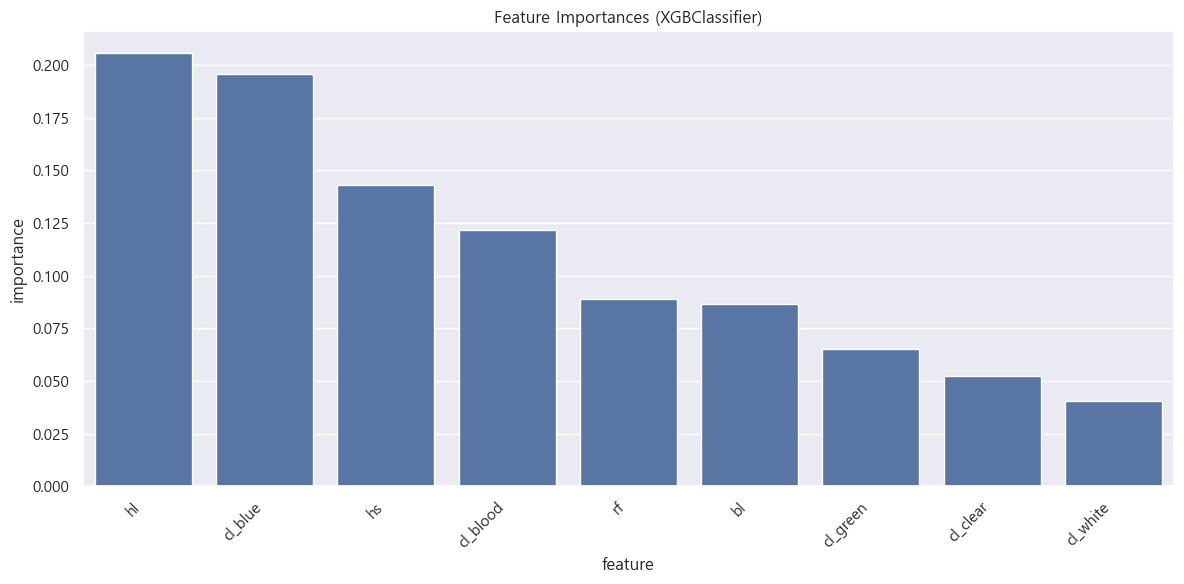

In [11]:
# 점수 확인을 위해 임시로 'cl' 컬럼을 원-핫 인코딩
# 다중공선성을 방지하기 위해 첫 번째 카테고리는 삭제
df_encoded = pd.get_dummies(df, columns=['cl'], drop_first=True)
myscore(target='tp', df=df_encoded, fi=True)

## 중간 제출

In [12]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 제출 파일(submission.csv)에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 타겟 변수(type)를 Label Encoding으로 숫자로 변환 ---
# 예측 결과를 다시 원래의 문자열('Ghoul', 'Goblin' 등)로 되돌리기 위해
# LabelEncoder 객체(le)를 저장해 둡니다.
le = LabelEncoder()
train_df['type'] = le.fit_transform(train_df['type'])


# --- 2-2. 학습 데이터와 테스트 데이터에서 피쳐(X)만 선택 ---
# 불필요한 'id'와 타겟 변수인 'type'을 제거합니다.
X_train = train_df.drop(columns=['id', 'type'])
X_test = test_df.drop(columns=['id'])


# --- 2-3. 'color' 피쳐를 원-핫 인코딩 ---
# 중요: 학습 데이터와 테스트 데이터의 컬럼을 동일하게 만들기 위해
# 두 데이터를 합쳤다가 인코딩 후 다시 분리합니다.
combined_df = pd.concat([X_train, X_test], keys=['train', 'test'])
combined_df_encoded = pd.get_dummies(combined_df, columns=['color'], drop_first=True)

# 다시 학습용과 테스트용으로 분리
X_train_final = combined_df_encoded.loc['train']
X_test_final = combined_df_encoded.loc['test']

# 타겟 변수(y) 정의
y_train_final = train_df['type']

print("학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# 가장 성능이 좋았던 모델 중 하나인 XGBClassifier를 사용합니다.
# 제출 시에는 모든 학습 데이터를 사용하여 모델의 성능을 극대화합니다.
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 학습된 모델로 테스트 데이터의 결과를 예측합니다.
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
# 캐글 제출 양식에 맞춰 DataFrame을 생성합니다.
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

# CSV 파일로 저장합니다. index=False는 불필요한 인덱스 컬럼이 저장되지 않도록 합니다.
submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.
학습 및 테스트 데이터 전처리 완료.
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


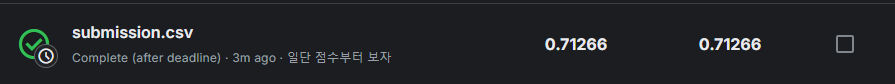

# 전처리 & 가공

## 인코딩 (dfe)

In [13]:
dfe = pd.get_dummies(df, columns=['cl'])

def tppop(df):
    tp_col = df.pop('tp')
    df['tp'] = tp_col

tppop(dfe)
dfe.head()

,bl,rf,hl,hs,cl_black,cl_blood,cl_blue,cl_clear,cl_green,cl_white,tp
0,0.354512,0.350839,0.465761,0.781142,False,False,False,True,False,False,Ghoul
1,0.575560,0.425868,0.531401,0.439899,False,False,False,False,True,False,Goblin
2,0.467875,0.354330,0.811616,0.791225,True,False,False,False,False,False,Ghoul
3,0.776652,0.508723,0.636766,0.884464,True,False,False,False,False,False,Ghoul
4,0.566117,0.875862,0.418594,0.636438,False,False,False,False,True,False,Ghost


## 이상치 처리 (dft)

In [14]:
numeric_cols = df.select_dtypes(include='number').columns
dft = dfe.copy()

for col in numeric_cols:

    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

print("Original data shape:", df.shape)
print("Data shape after removing outliers:", dft.shape)

Original data shape: (371, 6)
Data shape after removing outliers: (366, 11)


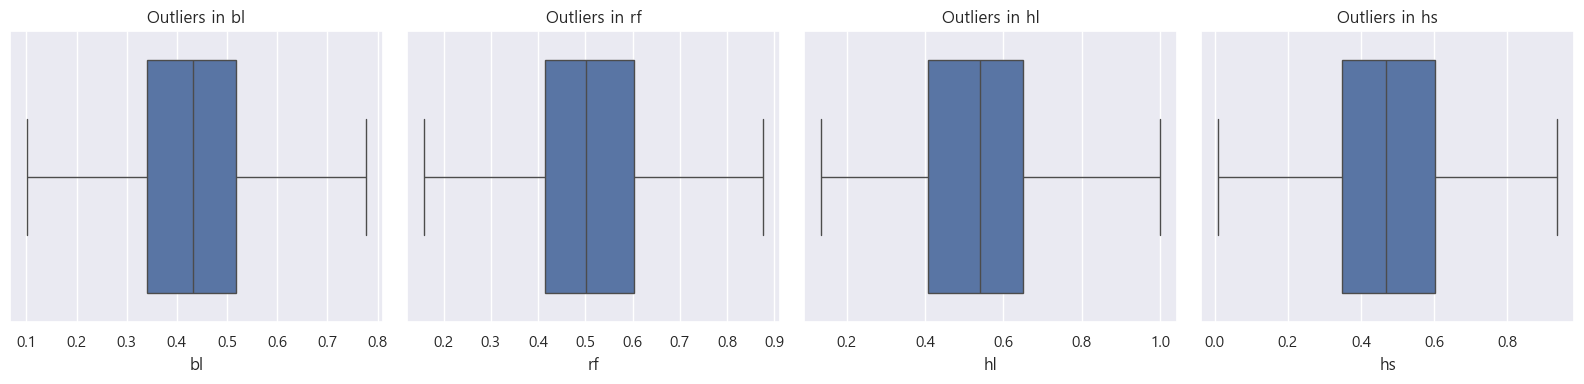

In [15]:
numeric_cols = dft.select_dtypes(include='number').columns

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:6]):
    sns.boxplot(x=dft[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

### 점수 확인

MODEL : XGBClassifier
Accuracy   : 0.70270
Precision  : 0.70679
Recall     : 0.70999
F1_Score   : 0.70252
LogLoss    : 0.97687
ROC_AUC    : 0.87145
------------------------------
🎉 New Best Accuracy Score Achieved! 🎉
--- Score Comparison (Current vs Best Accuracy) ---
Accuracy  : 0.70270 (Best: 0.70270) | Change: +0.00000 ➖
Precision : 0.70679 (Best: 0.70679) | Change: +0.00000 ➖
Recall    : 0.70999 (Best: 0.70999) | Change: +0.00000 ➖
F1_Score  : 0.70252 (Best: 0.70252) | Change: +0.00000 ➖
LogLoss   : 0.97687 (Best: 0.97687) | Change: +0.00000 ➖
ROC_AUC   : 0.87145 (Best: 0.87145) | Change: +0.00000 ➖
------------------------------



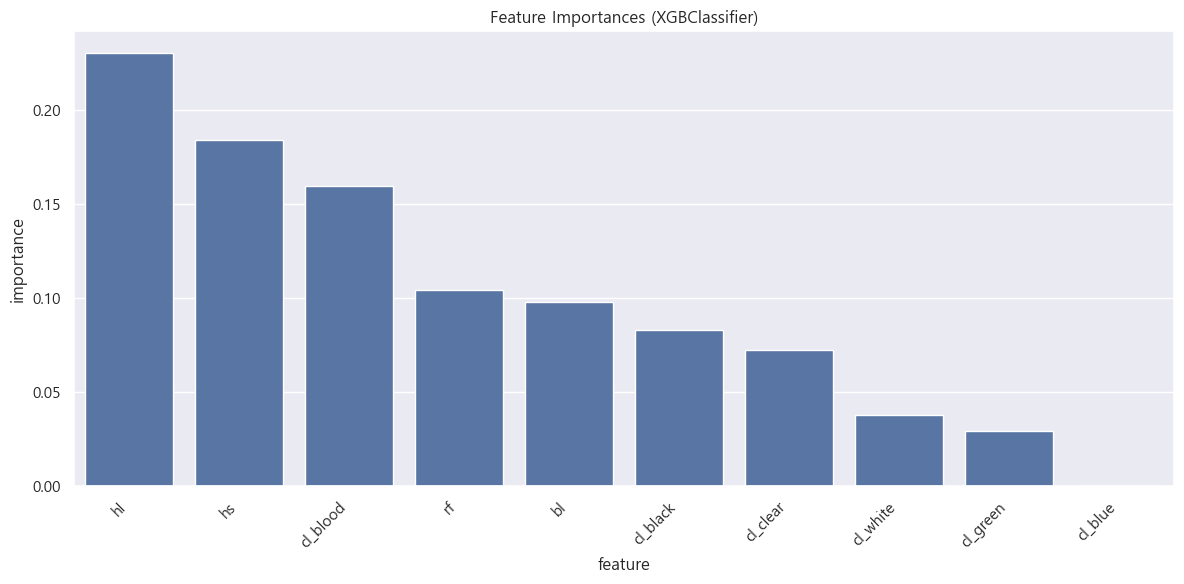

In [16]:
myscore(target='tp', df=dft, fi=True)

### 중간 제출

In [17]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)


# --- 2-4. 학습 데이터에만 이상치 제거 적용 ---
numeric_cols = train_df.select_dtypes(include='number').columns
dft = train_dfe.copy()

for col in numeric_cols:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

print(f"이상치 처리 전 학습 데이터 shape: {train_dfe.shape}")
print(f"이상치 처리 후 학습 데이터 shape: {dft.shape}")
# 중요: 테스트 세트의 데이터는 제거하지 않습니다. 모든 샘플을 예측해야 합니다.


# --- 2-5. 최종 데이터 준비 ---
# 타겟 변수 분리 및 레이블 인코딩
le = LabelEncoder()
y_train_final = le.fit_transform(dft['tp'])
X_train_final = dft.drop(columns=['tp'])

# 테스트 데이터는 전처리된 dfe를 그대로 사용
X_test_final = test_dfe.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
# 학습 과정에서 만들어진 컬럼이 테스트 데이터에 없을 수 있기 때문입니다.
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols] # 최종적으로 컬럼 순서까지 일치

print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 이상치가 제거된 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.
이상치 처리 전 학습 데이터 shape: (371, 11)
이상치 처리 후 학습 데이터 shape: (366, 11)

학습 및 테스트 데이터 전처리 완료.
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


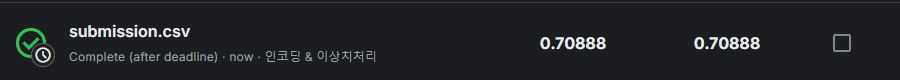

## 인코딩/이상치 처리 필요 확인

### 인코딩만

In [18]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 최종 데이터 준비 ---
# 이상치 처리 단계를 건너뛰고, 원-핫 인코딩된 데이터를 바로 사용합니다.
le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])

X_test_final = test_dfe.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols] # 최종적으로 컬럼 순서까지 일치

print("\n학습 및 테스트 데이터 전처리 완료. (이상치 처리 제외)")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 이상치가 제거되지 않은 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.

학습 및 테스트 데이터 전처리 완료. (이상치 처리 제외)
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


#### 중간 제출

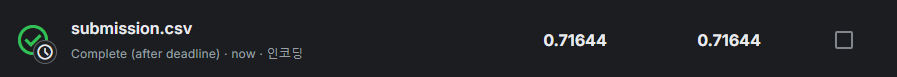

### 이상치 처리만 (Trimming)

In [19]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'cl'(color) 컬럼 제거 ---
# 인코딩을 하지 않으므로, 문자열인 'cl' 컬럼을 학습 데이터에서 제외합니다.
train_df = train_df.drop(columns=['cl'])
test_df = test_df.drop(columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_df = tppop(train_df)


# --- 2-4. 학습 데이터에만 이상치 제거 적용 ---
numeric_cols = train_df.select_dtypes(include='number').columns
dft = train_df.copy() # 원-핫 인코딩을 하지 않은 train_df를 복사

for col in numeric_cols:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

print(f"이상치 처리 전 학습 데이터 shape: {train_df.shape}")
print(f"이상치 처리 후 학습 데이터 shape: {dft.shape}")


# --- 2-5. 최종 데이터 준비 ---
# 타겟 변수 분리 및 레이블 인코딩
le = LabelEncoder()
y_train_final = le.fit_transform(dft['tp'])
X_train_final = dft.drop(columns=['tp'])

# 테스트 데이터는 'cl' 컬럼만 제거된 원본을 그대로 사용
X_test_final = test_df.copy()

print("\n학습 및 테스트 데이터 전처리 완료. ('cl' 컬럼 제외)")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 이상치가 제거된 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.
이상치 처리 전 학습 데이터 shape: (371, 5)
이상치 처리 후 학습 데이터 shape: (366, 5)

학습 및 테스트 데이터 전처리 완료. ('cl' 컬럼 제외)
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


#### 중간 제출

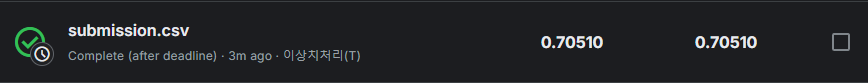

### 이상치 처리만 (Winsorization)

In [20]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'cl'(color) 컬럼 제거 ---
# 인코딩을 하지 않으므로, 문자열인 'cl' 컬럼을 학습 데이터에서 제외합니다.
train_df = train_df.drop(columns=['cl'])
test_df = test_df.drop(columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_df = tppop(train_df)


# --- 2-4. 학습 데이터에만 이상치 처리 적용 (Winsorization 방식) ---
# 중요: 테스트 데이터에는 이상치 처리를 적용하지 않습니다.
# 데이터의 분포가 달라져 모델 성능이 저하될 수 있습니다.
numeric_cols = train_df.select_dtypes(include='number').columns
dft = train_df.copy()

print("이상치 처리 (Winsorization) 적용 중...")
for col in numeric_cols:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # lower_bound보다 작은 값은 lower_bound로, upper_bound보다 큰 값은 upper_bound로 대체
    dft[col] = np.where(dft[col] < lower_bound, lower_bound, dft[col])
    dft[col] = np.where(dft[col] > upper_bound, upper_bound, dft[col])

# 윈저라이제이션은 데이터 shape이 변하지 않습니다.
print(f"처리 후 학습 데이터 shape: {dft.shape} (변경 없음)")


# --- 2-5. 최종 데이터 준비 ---
# 타겟 변수 분리 및 레이블 인코딩
le = LabelEncoder()
y_train_final = le.fit_transform(dft['tp'])
X_train_final = dft.drop(columns=['tp'])

# 테스트 데이터는 'cl' 컬럼만 제거된 원본을 그대로 사용
X_test_final = test_df.copy()

print("\n학습 및 테스트 데이터 전처리 완료. ('cl' 컬럼 제외, Winsorization 적용)")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 이상치가 처리된 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.
이상치 처리 (Winsorization) 적용 중...
처리 후 학습 데이터 shape: (371, 5) (변경 없음)

학습 및 테스트 데이터 전처리 완료. ('cl' 컬럼 제외, Winsorization 적용)
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


#### 중간 제출

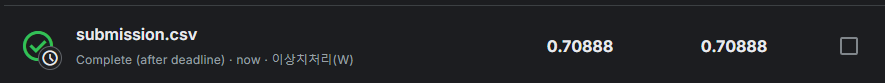

## 스케일링 (dfe)

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss'))
])

### 점수 확인

MODEL : Pipeline
Accuracy   : 0.72000
Precision  : 0.71276
Recall     : 0.72141
F1_Score   : 0.71405
LogLoss    : 0.94593
ROC_AUC    : 0.85643
------------------------------
🎉 New Best Accuracy Score Achieved! 🎉
--- Score Comparison (Current vs Best Accuracy) ---
Accuracy  : 0.72000 (Best: 0.72000) | Change: +0.00000 ➖
Precision : 0.71276 (Best: 0.71276) | Change: +0.00000 ➖
Recall    : 0.72141 (Best: 0.72141) | Change: +0.00000 ➖
F1_Score  : 0.71405 (Best: 0.71405) | Change: +0.00000 ➖
LogLoss   : 0.94593 (Best: 0.94593) | Change: +0.00000 ➖
ROC_AUC   : 0.85643 (Best: 0.85643) | Change: +0.00000 ➖
------------------------------



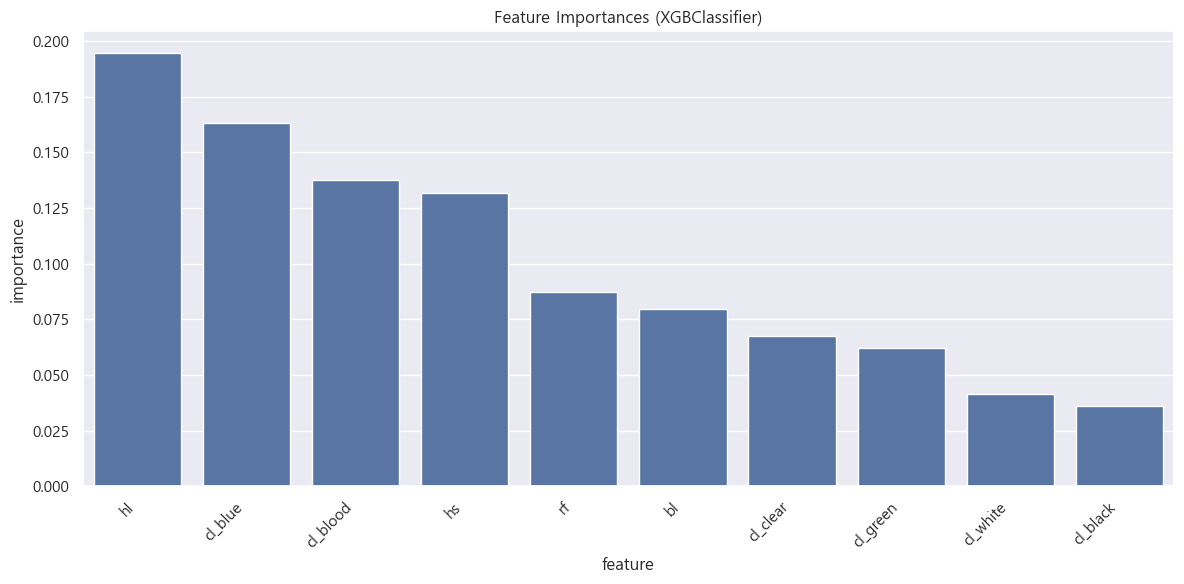

In [22]:
# 이상치 처리는 제외
myscore(target='tp', df=dfe, model=pipe, fi=True)

### 중간 제출

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 최종 데이터 준비 ---
# 이상치 처리 단계를 건너뛰고, 원-핫 인코딩된 데이터를 바로 사용합니다.
le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])

X_test_final = test_dfe.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols] # 최종적으로 컬럼 순서까지 일치

print("\n학습 및 테스트 데이터 전처리 완료. (이상치 처리 제외)")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# StandardScaler와 XGBClassifier를 포함하는 파이프라인을 최종 모델로 정의합니다.
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss'))
])

# 파이프라인을 사용하여 전체 학습 데이터로 모델을 훈련시킵니다.
# 데이터는 파이프라인 내부에서 자동으로 스케일링됩니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 파이프라인을 사용하여 예측을 수행합니다.
# 테스트 데이터는 학습 시 학습된 스케일러 기준으로 자동 변환됩니다.
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.

학습 및 테스트 데이터 전처리 완료. (이상치 처리 제외)
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


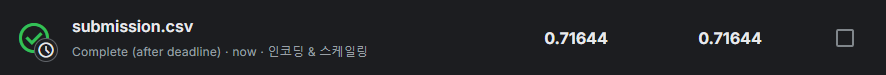

## 스케일링 방식 변경
* 기존엔 StandardScaler 였음

### MinMaxScaler

In [24]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 최종 데이터 준비 ---
le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])

X_test_final = test_dfe.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# StandardScaler 대신 MinMaxScaler를 사용하는 파이프라인을 정의합니다.
final_model = Pipeline([
    ('scaler', MinMaxScaler()), # <--- 스케일러 변경
    ('model', XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss'))
])

# 파이프라인을 사용하여 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 파이프라인을 사용하여 예측을 수행합니다.
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.

학습 및 테스트 데이터 전처리 완료.
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


#### 중간 제출

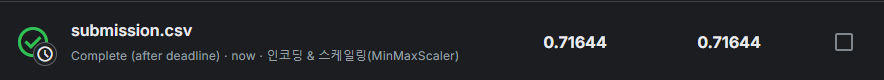

### RobustScaler

In [25]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 최종 데이터 준비 ---
le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])

X_test_final = test_dfe.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# MinMaxScaler 대신 RobustScaler를 사용하는 파이프라인을 정의합니다.
final_model = Pipeline([
    ('scaler', RobustScaler()), # <--- 스케일러 변경
    ('model', XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss'))
])

# 파이프라인을 사용하여 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 파이프라인을 사용하여 예측을 수행합니다.
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

데이터 로딩 완료.

학습 및 테스트 데이터 전처리 완료.
최종 모델 학습 완료.
테스트 데이터 예측 완료.

✅ submission.csv 파일 생성이 완료되었습니다!
제출 파일 미리보기:
   id    type
0   3   Ghoul
1   6  Goblin
2   9   Ghoul
3  10   Ghoul
4  13   Ghost


#### 중간 제출

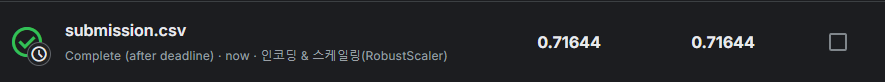

## 파생 피쳐 추가 (dff)

In [26]:
dff = dft.copy()

# 0으로 나누는 오류를 방지하기 위해 분모에 아주 작은 값(1e-6)을 더해줍니다.
dff['bl_rf_ratio'] = dff['bl'] / (dff['rf'] + 1e-6)
dff['bl_hl_ratio'] = dff['bl'] / (dff['hl'] + 1e-6)
dff['rf_hl_ratio'] = dff['rf'] / (dff['hl'] + 1e-6)

dff['humanoid_index'] = dff['bl'] * dff['hs']
dff['decay_index'] = dff['rf'] * dff['hl']
dff['body_sum'] = dff['bl'] + dff['rf'] + dff['hl']

tppop(dff)
dff.head()

,bl,rf,hl,hs,bl_rf_ratio,bl_hl_ratio,rf_hl_ratio,humanoid_index,decay_index,body_sum,tp
0,0.354512,0.350839,0.465761,0.781142,1.010467,0.761145,0.753258,0.276924,0.163407,1.171112,Ghoul
1,0.575560,0.425868,0.531401,0.439899,1.351494,1.083096,0.801405,0.253188,0.226307,1.532830,Goblin
2,0.467875,0.354330,0.811616,0.791225,1.320446,0.576473,0.436573,0.370195,0.287580,1.633822,Ghoul
3,0.776652,0.508723,0.636766,0.884464,1.526669,1.219682,0.798915,0.686921,0.323937,1.922141,Ghoul
4,0.566117,0.875862,0.418594,0.636438,0.646353,1.352422,2.092386,0.360298,0.366630,1.860572,Ghost


### 점수 확인

In [ ]:
myscore(target='tp', df=dff, fi=True)

### 중간 제출

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출 파일에 필요한 테스트 데이터의 id를 미리 저장합니다.
test_ids = test_df_raw['id']

print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 공통 전처리: id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. [추가된 부분] 파생 피쳐 생성 함수 정의 및 적용 ---
def create_features(df):
    """데이터프레임에 파생 피쳐를 추가합니다."""
    # 0으로 나누는 오류 방지를 위해 분모에 작은 값(1e-6)을 더합니다.
    df['bl_rf_ratio'] = df['bl'] / (df['rf'] + 1e-6)
    df['bl_hl_ratio'] = df['bl'] / (df['hl'] + 1e-6)
    df['rf_hl_ratio'] = df['rf'] / (df['hl'] + 1e-6)
    
    # 상호작용 피쳐
    df['humanoid_index'] = df['bl'] * df['hs']
    df['decay_index'] = df['rf'] * df['hl']
    df['body_sum'] = df['bl'] + df['rf'] + df['hl']
    return df

# 학습 데이터와 테스트 데이터에 동일하게 함수를 적용합니다.
train_dff = create_features(train_dfe)
test_dff = create_features(test_dfe)

print("파생 피쳐 생성 완료.")


# --- 2-4. 타겟 변수('tp')를 맨 뒤로 이동시키는 함수 정의 및 적용 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dff = tppop(train_dff)


# --- 2-5. 최종 데이터 준비 ---
le = LabelEncoder()
y_train_final = le.fit_transform(train_dff['tp'])
X_train_final = train_dff.drop(columns=['tp'])

X_test_final = test_dff.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서 및 개수를 동일하게 맞춤
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols] # 최종적으로 컬럼 순서까지 일치

print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 파생 피쳐가 추가된 전체 학습 데이터로 모델을 훈련시킵니다.
final_model.fit(X_train_final, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)

# 예측된 숫자(0, 1, 2)를 다시 원래의 문자열('Ghoul', 'Goblin', 'Ghost')로 변환합니다.
predictions = le.inverse_transform(predictions_numeric)

print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

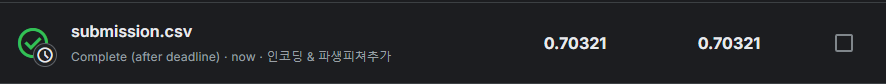

## 피쳐 셀렉션

In [ ]:
# 원본 데이터프레임(df)을 복사하여 인코딩 진행
df_encoded = dff.copy()

# 'cl'과 'tp' 컬럼을 레이블 인코딩으로 숫자로 변환
le = LabelEncoder()
df_encoded['tp'] = le.fit_transform(df_encoded['tp'])

# --- 이제 모든 컬럼이 숫자이므로 히트맵 생성 가능 ---
plt.figure(figsize=(10, 7)) # figsize를 조금 키워 가독성 확보

# 상관관계 행렬 계산
corr_matrix = df_encoded.corr()

# 히트맵 마스크 생성 (중복되는 상단 삼각형 가리기)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap (Encoded Features)')
plt.show()

### 점수 확인

### 중간 제출

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (이전과 동일)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (이전과 동일)
# ==============================================================================
# --- 2-1. 공통 전처리 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']
test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 파생 피쳐 생성 ---
def create_features(df):
    df['bl_rf_ratio'] = df['bl'] / (df['rf'] + 1e-6)
    df['bl_hl_ratio'] = df['bl'] / (df['hl'] + 1e-6)
    df['rf_hl_ratio'] = df['rf'] / (df['hl'] + 1e-6)
    df['humanoid_index'] = df['bl'] * df['hs']
    df['decay_index'] = df['rf'] * df['hl']
    df['body_sum'] = df['bl'] + df['rf'] + df['hl']
    return df

train_dff = create_features(train_dfe)
test_dff = create_features(test_dfe)
print("파생 피쳐 생성 완료.")

# --- 2-4. 타겟 변수 처리 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df
train_dff = tppop(train_dff)

# --- 2-5. 최종 데이터 준비 ---
le = LabelEncoder()
y_train_final = le.fit_transform(train_dff['tp'])
X_train_final = train_dff.drop(columns=['tp'])
X_test_final = test_dff.copy()

# 컬럼 맞추기
train_cols = X_train_final.columns
test_cols = X_test_final.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0
X_test_final = X_test_final[train_cols]
print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. 모델 학습 및 피쳐 선택 (⭐ 변경된 부분 ⭐)
# ==============================================================================
# 기준 모델로 사용할 XGBClassifier 정의
xgb_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# 먼저 전체 피쳐로 모델을 한 번 학습시킵니다.
xgb_model.fit(X_train_final, y_train_final)
print("피쳐 선택을 위한 기준 모델 학습 완료.")

# SelectFromModel을 사용해 중요한 피쳐를 선택합니다.
# threshold='median'은 중요도가 중간값 이상인 피쳐들만 선택하라는 의미입니다.
selector = SelectFromModel(xgb_model, prefit=True, threshold='median')

# 학습 데이터와 테스트 데이터에서 중요한 피쳐들만 남깁니다.
X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

print(f"피쳐 선택 완료: {X_train_final.shape[1]}개 -> {X_train_selected.shape[1]}개")


# ==============================================================================
# 4. 최종 모델 학습 (선택된 피쳐 사용)
# ==============================================================================
# 최종 모델을 새로 정의합니다. (동일한 모델 사용)
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# **선택된 피쳐(X_train_selected)**로 최종 모델을 훈련시킵니다.
final_model.fit(X_train_selected, y_train_final)
print("선택된 피쳐로 최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 및 제출 파일 생성 (이전과 동일)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")

submission_df = pd.DataFrame({ "id": test_ids, "type": predictions })
submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print(submission_df.head())

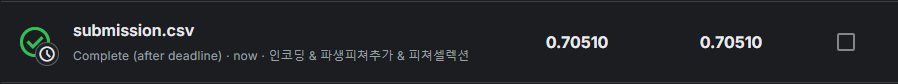

## 피쳐 셀렉션 방식 변경

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (이전과 동일)
# ==============================================================================
# 데이터 경로를 실제 환경에 맞게 수정해주세요.
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")

# ==============================================================================
# 2. 전처리 (이전과 동일)
# ==============================================================================
# --- 2-1. 공통 전처리 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']
test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 파생 피쳐 생성 ---
def create_features(df):
    df['bl_rf_ratio'] = df['bl'] / (df['rf'] + 1e-6)
    df['bl_hl_ratio'] = df['bl'] / (df['hl'] + 1e-6)
    df['rf_hl_ratio'] = df['rf'] / (df['hl'] + 1e-6)
    df['humanoid_index'] = df['bl'] * df['hs']
    df['decay_index'] = df['rf'] * df['hl']
    df['body_sum'] = df['bl'] + df['rf'] + df['hl']
    return df

train_dff = create_features(train_dfe)
test_dff = create_features(test_dfe)
print("파생 피쳐 생성 완료.")

# --- 2-4. 타겟 변수 처리 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df
train_dff = tppop(train_dff)

# --- 2-5. 최종 데이터 준비 ---
le = LabelEncoder()
y_train_final = le.fit_transform(train_dff['tp'])
X_train_final = train_dff.drop(columns=['tp'])
X_test_final = test_dff.copy()

# 컬럼 맞추기
train_cols = X_train_final.columns
test_cols = X_test_final.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0
X_test_final = X_test_final[train_cols]
print("\n학습 및 테스트 데이터 전처리 완료.")


# ==============================================================================
# 3. RFE를 이용한 피쳐 선택 (⭐ 변경된 부분 ⭐)
# ==============================================================================
# RFE에 사용할 기본 모델 정의
base_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# RFE 객체 생성
# n_features_to_select는 최종적으로 선택할 피쳐의 개수입니다. 이 값을 조절하며 실험해볼 수 있습니다.
selector = RFE(estimator=base_model, n_features_to_select=10, step=1)

# RFE를 실행하여 학습 데이터에 맞추고, 중요한 피쳐만 남깁니다.
X_train_selected = selector.fit_transform(X_train_final, y_train_final)
# 학습된 selector를 사용하여 테스트 데이터에도 동일한 피쳐를 선택합니다.
X_test_selected = selector.transform(X_test_final)

# 어떤 피쳐가 선택되었는지 확인
selected_features = X_train_final.columns[selector.support_]
print(f"\n피쳐 선택 완료: {X_train_final.shape[1]}개 -> {X_train_selected.shape[1]}개")
print(f"선택된 피쳐: {selected_features.tolist()}")


# ==============================================================================
# 4. 최종 모델 학습 (선택된 피쳐 사용)
# ==============================================================================
# 최종 모델을 새로 정의합니다. (동일한 모델 사용)
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')

# **선택된 피쳐(X_train_selected)**로 최종 모델을 훈련시킵니다.
final_model.fit(X_train_selected, y_train_final)
print("\n선택된 피쳐로 최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 및 제출 파일 생성 (이전과 동일)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")

submission_df = pd.DataFrame({ "id": test_ids, "type": predictions })
submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print(submission_df.head())

### 중간 제출

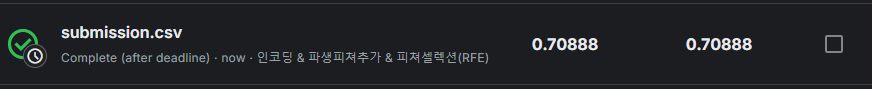

## 파생 피쳐 없이 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']


# --- 2-2. 'color'(cl) 피쳐 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])


# --- 2-3. 타겟 컬럼 맨 뒤로 이동 ---
def tppop(df):
    """데이터프레임에서 'tp' 컬럼을 맨 뒤로 이동시킵니다."""
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)


# --- 2-4. 학습/테스트 데이터 준비 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# 컬럼 정렬 통일
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n학습 및 테스트 데이터 전처리 완료. (이상치 처리 제외)")


# ==============================================================================
# 3. Feature Selection (SelectFromModel)
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 임시 모델로 중요도 계산
selector_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')
selector_model.fit(X_train_final, y_train_final)

# SelectFromModel 적용 (threshold는 평균보다 큰 feature만 남김)
selector = SelectFromModel(selector_model, threshold="mean", prefit=True)

# 선택된 피처로 데이터 축소
X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

# 선택된 피처 이름 확인
selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 사용)
# ==============================================================================
final_model = XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train_selected, y_train_final)

print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터 사용)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성이 완료되었습니다!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 점수 확인

### 중간 제출

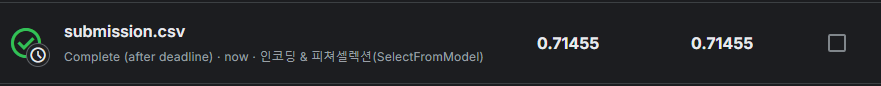

# 기본 모델로 점수 확인

In [ ]:
model_list = [
    XGBClassifier(random_state=8989, use_label_encoder=False, eval_metric='logloss'),
    RandomForestClassifier(random_state=8989),
    LogisticRegression(random_state=8989),
    SVC(random_state=8989, probability=True),
    KNeighborsClassifier()
]

for model in model_list:
    model_name = model.__class__.__name__
    if isinstance(model, Pipeline):
        model_name = model.steps[-1][1].__class__.__name__
    
    print(f"========== Evaluating Model: {model_name} ==========")

    myscore(target='tp', df=dff, model=model)
    print("\n\n")

## 중간 제출 (XGBClassifier)

### 인코딩

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

# test에 없는 컬럼 추가 (0으로 채움)
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

# train에 없는 컬럼도 0으로 맞춤 (안정성 확보)
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

# 컬럼 순서 일치
X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. 모델 학습 (XGBClassifier)
# ==============================================================================
from xgboost import XGBClassifier

final_model = XGBClassifier(
    random_state=8989,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(X_train_final, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 인코딩 & 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. Feature Selection (SelectFromModel)
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 1️⃣ 임시 XGB 모델 학습
selector_model = XGBClassifier(
    random_state=8989,
    use_label_encoder=False,
    eval_metric='logloss'
)
selector_model.fit(X_train_final, y_train_final)

# 2️⃣ SelectFromModel 적용 — 평균 이상 중요도만 선택
selector = SelectFromModel(selector_model, threshold="mean", prefit=True)

# 3️⃣ 선택된 피처로 데이터 축소
X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

# 선택된 피처 이름 추출
selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 기반 XGBClassifier)
# ==============================================================================
final_model = XGBClassifier(
    random_state=8989,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(X_train_selected, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())


## 중간 제출 (RandomForestClassifier)

### 인코딩

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. 모델 학습 (RandomForestClassifier)
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier

final_model = RandomForestClassifier(
    random_state=8989,
    n_estimators=200,
    max_depth=None,
    n_jobs=-1
)

final_model.fit(X_train_final, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 인코딩 & 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. Feature Selection (SelectFromModel with RandomForest)
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 1️⃣ 임시 RandomForest 모델 학습
selector_model = RandomForestClassifier(
    random_state=8989,
    n_estimators=300,
    max_depth=None,
    n_jobs=-1
)
selector_model.fit(X_train_final, y_train_final)

# 2️⃣ SelectFromModel 적용 — 평균 이상 중요도만 선택
selector = SelectFromModel(selector_model, threshold="mean", prefit=True)

# 3️⃣ 선택된 피처로 데이터 축소
X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

# 선택된 피처 이름 추출
selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 기반 RandomForest)
# ==============================================================================
final_model = RandomForestClassifier(
    random_state=8989,
    n_estimators=300,
    max_depth=None,
    n_jobs=-1
)

final_model.fit(X_train_selected, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

## 중간 제출 (LogisticRegression)

### 인코딩

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. 모델 학습 (LogisticRegression)
# ==============================================================================
from sklearn.linear_model import LogisticRegression

final_model = LogisticRegression(
    random_state=8989,
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial'
)

final_model.fit(X_train_final, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_final)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 인코딩 & 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. Feature Selection (SelectFromModel with LogisticRegression)
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 스케일링(LogisticRegression은 스케일에 민감)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# 1️⃣ 임시 LogisticRegression 모델 학습
selector_model = LogisticRegression(
    random_state=8989,
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    penalty='l2'
)
selector_model.fit(X_train_scaled, y_train_final)

# 2️⃣ SelectFromModel 적용 — 평균 이상 중요도만 선택
selector = SelectFromModel(selector_model, threshold="mean", prefit=True)

# 3️⃣ 선택된 피처로 데이터 축소
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# 선택된 피처 이름 추출
selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 기반 LogisticRegression)
# ==============================================================================
final_model = LogisticRegression(
    random_state=8989,
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    penalty='l2'
)

final_model.fit(X_train_selected, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

## 중간 제출 (SVC)

### 인코딩

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. 모델 학습 (SVC)
# ==============================================================================
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# SVM은 스케일링이 매우 중요하므로 정규화 추가
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

final_model = SVC(
    kernel='rbf',      # 기본 RBF 커널
    C=1.0,             # 규제 강도
    gamma='scale',     # 자동 스케일
    probability=True,  # 필요시 확률 예측 가능하게
    random_state=8989
)

final_model.fit(X_train_scaled, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_scaled)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 인코딩 & 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. Feature Selection (SelectFromModel with Linear SVC)
# ==============================================================================
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 스케일링 (SVM은 스케일에 민감)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# 1️⃣ 임시 LinearSVC 모델 학습 (선형 SVM만 feature_importance 대체 가능)
selector_model = LinearSVC(
    random_state=8989,
    penalty='l2',
    C=1.0,
    max_iter=3000
)
selector_model.fit(X_train_scaled, y_train_final)

# 2️⃣ SelectFromModel 적용 — 평균 이상 중요도만 선택
selector = SelectFromModel(selector_model, threshold="mean", prefit=True)

# 3️⃣ 선택된 피처로 데이터 축소
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# 선택된 피처 이름 추출
selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 기반 SVC)
# ==============================================================================
from sklearn.svm import SVC

final_model = SVC(
    kernel='rbf',       # RBF 커널 (비선형)
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=8989
)

final_model.fit(X_train_selected, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_selected)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

## 중간 제출 (KNeighborsClassifier)

### 인코딩

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. 모델 학습 (KNeighborsClassifier)
# ==============================================================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# KNN은 거리 기반 모델이므로 스케일링 필수
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

final_model = KNeighborsClassifier(
    n_neighbors=5,   # 기본 k=5
    weights='distance',  # 가까운 이웃에 더 큰 가중치 부여
    n_jobs=-1         # 병렬 처리
)

final_model.fit(X_train_scaled, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 4. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_scaled)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

### 인코딩 & 피쳐 셀렉션

In [ ]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
train_df_raw = pd.read_csv('../data/train.csv')
test_df_raw = pd.read_csv('../data/test.csv')

# 제출용 id 저장
test_ids = test_df_raw['id']
print("데이터 로딩 완료.")


# ==============================================================================
# 2. 전처리 (인코딩만 적용)
# ==============================================================================
# --- 2-1. id 제거 및 컬럼명 변경 ---
train_df = train_df_raw.drop('id', axis=1)
train_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl', 'tp']

test_df = test_df_raw.drop('id', axis=1)
test_df.columns = ['bl', 'rf', 'hl', 'hs', 'cl']

# --- 2-2. color(cl) 원-핫 인코딩 ---
train_dfe = pd.get_dummies(train_df, columns=['cl'])
test_dfe = pd.get_dummies(test_df, columns=['cl'])

# --- 2-3. 타겟 컬럼을 맨 뒤로 이동 ---
def tppop(df):
    if 'tp' in df.columns:
        tp_col = df.pop('tp')
        df['tp'] = tp_col
    return df

train_dfe = tppop(train_dfe)

# --- 2-4. 타겟 분리 및 컬럼 정렬 통일 ---
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
y_train_final = le.fit_transform(train_dfe['tp'])
X_train_final = train_dfe.drop(columns=['tp'])
X_test_final = test_dfe.copy()

# train/test 컬럼 일치
train_cols = X_train_final.columns
test_cols = X_test_final.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_final[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_final[c] = 0

X_test_final = X_test_final[train_cols]

print("\n✅ 인코딩 완료 및 컬럼 정렬 통일")


# ==============================================================================
# 3. Feature Selection (SelectFromModel with RandomForest)
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

print("\n🎯 Feature Selection 단계 시작...")

# 임시 RandomForest 모델로 중요도 기반 피처 선택
selector_model = RandomForestClassifier(
    random_state=8989,
    n_estimators=300,
    max_depth=None,
    n_jobs=-1
)
selector_model.fit(X_train_final, y_train_final)

selector = SelectFromModel(selector_model, threshold="mean", prefit=True)
X_train_selected = selector.transform(X_train_final)
X_test_selected = selector.transform(X_test_final)

selected_features = X_train_final.columns[selector.get_support()]
print(f"선택된 피처 수: {len(selected_features)} / {X_train_final.shape[1]}")
print("선택된 주요 피처 목록:")
print(list(selected_features))

print("\nFeature Selection 완료.")


# ==============================================================================
# 4. 모델 학습 (선택된 피처 기반 KNeighborsClassifier)
# ==============================================================================
from sklearn.neighbors import KNeighborsClassifier

# KNN은 거리 기반이므로 스케일링 필수
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

final_model = KNeighborsClassifier(
    n_neighbors=5,       # 이웃 개수
    weights='distance',  # 가까운 이웃에 더 높은 가중치
    n_jobs=-1            # 병렬 처리
)

final_model.fit(X_train_scaled, y_train_final)
print("최종 모델 학습 완료.")


# ==============================================================================
# 5. 예측 (테스트 데이터)
# ==============================================================================
predictions_numeric = final_model.predict(X_test_scaled)
predictions = le.inverse_transform(predictions_numeric)
print("테스트 데이터 예측 완료.")


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission_df = pd.DataFrame({
    "id": test_ids,
    "type": predictions
})

submission_df.to_csv("submission.csv", index=False)

print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission_df.head())

## 중간 결과 정리
* LogisticRegression & 인코딩 & 피쳐 셀렉션이 0.74291로 점수 제일 높음

### 점수 확인

### 점수 제출 정리

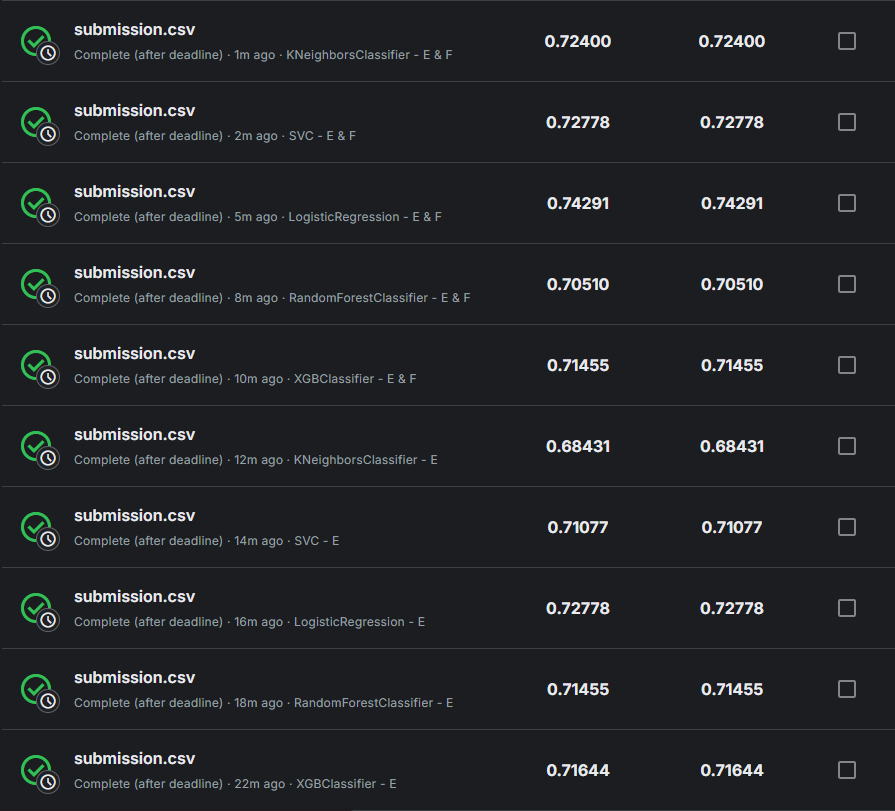

# 하이퍼파라미터 최적화

## RandomizedSearchCV

### 점수 확인

### 중간 제출

## GridSearchCV

### 점수 확인

### 중간 제출

# 앙상블

## VotingClassifier

### 점수 확인

### 중간 제출

## BaggingClassifier

### 점수 확인

### 중간 제출

## StackingClassifier

### 점수 확인

### 중간 제출